In [1]:
# import libaries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import tqdm
import tensorboardX
import logging
import os
import time
import random
import tifffile

In [2]:
# set random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# set hyperparameters
task = '2chnto4chn_ResVAE_fixedLoss'
batch_size = 128
learning_rate = 0.3
num_epochs = 500
latent_dim = 128
# hidden_dim = [32, 64, 128]
layer_list = [2, 2, 2, 2]
in_channels = 2
input_channel_idx = [0, 1]
load_checkpoint_path = 'checkpoints/Fixed20_Res_VAE-sigma_0.001-larger_newNormalize/2023-07-20_16-03-59/VAE_Epoch_500_Loss_13549153273856.0.pth'

time_stamp = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

checkpoint_dir = os.path.join('checkpoints', task, time_stamp)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

log_dir = os.path.join('logs', task, time_stamp)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logger.addHandler(logging.FileHandler(os.path.join(log_dir, 'log.txt')))
logger.info('task: {}'.format(task))
logger.info('device: {}'.format(device))
logger.info('batch_size: {}'.format(batch_size))
logger.info('learning_rate: {}'.format(learning_rate))
logger.info('num_epochs: {}'.format(num_epochs))
logger.info('latent_dim: {}'.format(latent_dim))
logger.info('layer_list: {}'.format(layer_list))
logger.info('input_channels: {}'.format(in_channels))
logger.info('input_channel_idx: {}'.format(input_channel_idx))
logger.info('load_checkpoint_path: {}'.format(load_checkpoint_path))
# logger.info('num_classes: {}'.format(num_classes))

writer = tensorboardX.SummaryWriter(log_dir)

# tensorboard --logdir=logs --port=6006


2023-07-25 16:36:46,649 - INFO - task: 2chnto4chn_ResVAE_fixedLoss
2023-07-25 16:36:46,650 - INFO - device: cuda
2023-07-25 16:36:46,650 - INFO - batch_size: 128
2023-07-25 16:36:46,650 - INFO - learning_rate: 0.3
2023-07-25 16:36:46,651 - INFO - num_epochs: 500
2023-07-25 16:36:46,651 - INFO - latent_dim: 128
2023-07-25 16:36:46,652 - INFO - layer_list: [2, 2, 2, 2]
2023-07-25 16:36:46,652 - INFO - input_channels: 2
2023-07-25 16:36:46,653 - INFO - input_channel_idx: [0, 1]
2023-07-25 16:36:46,653 - INFO - load_checkpoint_path: checkpoints/Fixed20_Res_VAE-sigma_0.001-larger_newNormalize/2023-07-20_16-03-59/VAE_Epoch_500_Loss_13549153273856.0.pth


c:\Users\hx57\AppData\Local\anaconda3\envs\jra\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([2, 32, 32]) torch.float32
tensor([-0.9341, -0.9329, -0.9286, -0.9242, -0.9234, -0.9235, -0.9220, -0.9173,
        -0.9127, -0.9032, -0.8932, -0.8876, -0.8879, -0.8883, -0.8824, -0.8763,
        -0.8806, -0.8952, -0.9093, -0.9107, -0.9121, -0.9146, -0.9180, -0.9220,
        -0.9307, -0.9394, -0.9440, -0.9462, -0.9478, -0.9461, -0.9444, -0.9439])


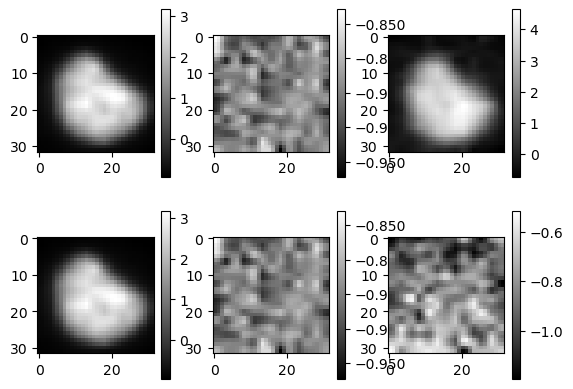

In [5]:
# load data
mean = torch.tensor([6076.685883679818, 1350.9691095158794, 5090.145564947434, 5019.978020658786])
std = torch.tensor([5504.395544161098, 1145.6356702621574, 663.3312283427825, 706.0040270727409])
data_path = os.path.join(os.getcwd(), 'data/single_cell_data/')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std), transforms.Resize((32, 32))])


class CellDataset(Dataset):
    def __init__(self, data_path, input_channel_index, transform=None):
        self.transform = transform
        self.data_path = data_path
        self.input_channel_index = input_channel_index
        self.data = os.listdir(data_path)
        self.data.sort()
        self.data = [os.path.join(data_path, i) for i in self.data]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = tifffile.imread(self.data[idx])
        img = img.astype(np.float32)
        # print(img[0][0])
        img = np.transpose(img, (1, 2, 0))
        if self.transform:
            img = self.transform(img)
        x = img[self.input_channel_index]
        return x, img
    
dataset = CellDataset(data_path, input_channel_index=input_channel_idx, transform=trans)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# test CellDataset
idx = 3
img, target = dataset[idx]
print(img.shape, img.dtype)
print(img[0][0])
fig = plt.figure()
plt.subplot(2, 3, 1)
plt.imshow(img[0], cmap='gray')
plt.colorbar()
plt.subplot(2, 3, 2)
plt.imshow(img[1], cmap='gray')
plt.colorbar()
plt.subplot(2, 3, 3)
plt.imshow(target[3], cmap='gray')
plt.colorbar()
plt.subplot(2, 3, 4)
plt.imshow(target[0], cmap='gray')
plt.colorbar()
plt.subplot(2, 3, 5)
plt.imshow(target[1], cmap='gray')
plt.colorbar()
plt.subplot(2, 3, 6)
plt.imshow(target[2], cmap='gray')
plt.colorbar()
plt.show()


In [6]:
# define VAE model
import math
def calc_activation_shape(dim, ksize=(5, 5), stride=(1, 1), padding=(0, 0), dilation=(1, 1), output_padding=(0, 0),
                          transposed=False):
    def shape_each_dim(i):
        if transposed:
            odim_i = (dim[i] - 1) * stride[i] - 2 * padding[i] + dilation[i] * (ksize[i] - 1) + 1 + output_padding[i]
        else:
            odim_i = dim[i] + 2 * padding[i] - dilation[i] * (ksize[i] - 1) - 1
            odim_i = odim_i / stride[i] + 1
        return math.floor(odim_i)

    return shape_each_dim(0), shape_each_dim(1)



class EncoderBottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, ln_shape, use_batch_norm=True, stride=1, downsample=None):
        super(EncoderBottleneckBlock, self).__init__()
        ln_shape = calc_activation_shape(ln_shape, ksize=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.norm_1 = nn.BatchNorm2d(planes) if use_batch_norm else nn.LayerNorm([planes, *ln_shape])

        ln_shape = calc_activation_shape(ln_shape, ksize=(5, 5), stride=(stride, stride), padding=(2, 2))
        self.conv_2 = nn.Conv2d(planes, planes, kernel_size=5, stride=stride, padding=2, bias=False)
        self.norm_2 = nn.BatchNorm2d(planes) if use_batch_norm else nn.LayerNorm([planes, *ln_shape])

        ln_shape = calc_activation_shape(ln_shape, ksize=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.norm_3 = nn.BatchNorm2d(planes * self.expansion) if use_batch_norm else nn.LayerNorm([planes * self.expansion, *ln_shape])

        self.relu = nn.LeakyReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv_1(x)

        out = self.norm_1(out)
        out = self.relu(out)

        out = self.conv_2(out)
        out = self.norm_2(out)
        out = self.relu(out)

        out = self.conv_3(out)
        out = self.norm_3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Encoder(nn.Module):

    def __init__(self, in_channels, latent_dim, use_batch_norm, dropout, layers):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.use_batch_norm = use_batch_norm
        self.dropout = dropout
        self.layers = layers

        self.ln_shape = (32, 32)

        self.conv_1 = nn.Conv2d(in_channels, 8, kernel_size=3, stride=2, padding=1, bias=False)
        self.inplanes = 8

        self.ln_shape = calc_activation_shape(self.ln_shape, ksize=(3, 3), stride=(2, 2), padding=(1, 1))
        self.norm_layer_1 = nn.BatchNorm2d(8) if use_batch_norm else nn.LayerNorm([8, *self.ln_shape])
        self.relu = nn.LeakyReLU(inplace=True)

        self.layer_1 = self._make_layer(8, layers[0], stride=2)
        self.layer_2 = self._make_layer(8, layers[1], stride=2)
        self.layer_3 = self._make_layer(16, layers[2], stride=2)
        self.layer_4 = self._make_layer(32, layers[3])

        self.conv_1x1 = nn.Sequential(nn.Conv2d(128, 16, kernel_size=1),
                                      nn.BatchNorm2d(16) if use_batch_norm else nn.LayerNorm([16, *self.ln_shape]),
                                      nn.LeakyReLU(inplace=True))

        linear_dim = 16 * self.ln_shape[0] * self.ln_shape[1]
        self.fc_mu = nn.Linear(linear_dim, latent_dim)
        self.fc_var = nn.Linear(linear_dim, latent_dim)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None
        ln_shape = calc_activation_shape(self.ln_shape, ksize=(5, 5), stride=(stride, stride), padding=(2, 2))
        if stride != 1 or self.inplanes != planes * EncoderBottleneckBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * EncoderBottleneckBlock.expansion,
                          kernel_size=5, padding=2, stride=stride, bias=False),
                nn.BatchNorm2d(planes * EncoderBottleneckBlock.expansion) if self.use_batch_norm else nn.LayerNorm([planes * EncoderBottleneckBlock.expansion, *ln_shape]),
            )

        layers = [EncoderBottleneckBlock(self.inplanes, planes, self.ln_shape, self.use_batch_norm, stride, downsample)]

        self.inplanes = planes * EncoderBottleneckBlock.expansion

        for i in range(1, blocks):
            layers.append(EncoderBottleneckBlock(self.inplanes, planes, ln_shape, self.use_batch_norm))

        self.ln_shape = ln_shape

        return nn.Sequential(*layers)

    def encode(self, x):
        """
        Pass the input to the encoder and get the latent distribution
        :param x: input of shape (B, C, H, W)
        :return: vectors mu and log_var produced by the encoder
        """
        # Compute encoder output
        x = self.conv_1(x)
        x = self.norm_layer_1(x)
        x = self.relu(x)

        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.conv_1x1(x)
        # print(x.shape)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)

        return mu, log_var

    def forward(self, x):
        """
        Get the latent encoding of the data_loaders and sample z from a learned distribution
        :param x: input of shape (B, C, H, W)
        :return: sample from the distribution q_zx,
                 a list containing mu and sigma vectors
        """
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)

        return [z, mu, log_var]

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick
        :param mu: vector of means produced by the encoder
        :param log_var: vector of log variances produced by the encoder
        :return: sample from the distribution parametrized by mu and var
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + std * eps


class DecoderBottleneckBlock(nn.Module):
    expansion = 4  # expansion factor

    def __init__(self, in_channels, planes, ln_shape, use_batch_norm=False, upsample=None, stride=2, output_padding=0):
        super(DecoderBottleneckBlock, self).__init__()

        self.upsample = upsample
        self.stride = stride
        self.use_batch_norm = use_batch_norm

        ln_shape = calc_activation_shape(ln_shape, ksize=(1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1), output_padding=(0, 0), transposed=True)
        self.conv_1 = nn.ConvTranspose2d(in_channels, planes, kernel_size=1, stride=1, padding=0)
        self.norm_1 = nn.BatchNorm2d(planes) if self.use_batch_norm else nn.LayerNorm([planes, *ln_shape])

        ln_shape = calc_activation_shape(ln_shape, ksize=(5, 5), stride=(stride, stride), padding=(2, 2), dilation=(1, 1), output_padding=(output_padding, output_padding), transposed=True)
        self.conv_2 = nn.ConvTranspose2d(planes, planes, kernel_size=5, stride=self.stride, padding=2, output_padding=output_padding)
        self.norm_2 = nn.BatchNorm2d(planes) if self.use_batch_norm else nn.LayerNorm([planes, *ln_shape])

        ln_shape = calc_activation_shape(ln_shape, ksize=(1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1), output_padding=(0, 0), transposed=True)
        self.conv_3 = nn.ConvTranspose2d(planes, planes * self.expansion, kernel_size=1, stride=1, padding=0)
        self.norm_3 = nn.BatchNorm2d(planes * self.expansion) if self.use_batch_norm else nn.LayerNorm([planes * self.expansion, *ln_shape])

        self.relu = nn.LeakyReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.norm_1(self.conv_1(x)))
        x = self.relu(self.norm_2(self.conv_2(x)))
        x = self.relu(self.norm_3(self.conv_3(x)))

        if self.upsample is not None:
            identity = self.upsample(identity)

        x = x + identity
        x = self.relu(x)

        return x


class Decoder(nn.Module):

    def __init__(self, latent_dim, use_batch_norm, dropout, layers=[1, 1, 1, 1]):
        """
        :param latent_dim: size of the latent space
        """
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.use_batch_norm = use_batch_norm
        self.dropout = dropout
        self.layers = layers
        # self.ln_shape = (8, 8)
        self.ln_shape = (2, 2)

        self.in_channels = 16
        linear_dim = self.in_channels * self.ln_shape[0] * self.ln_shape[1]
        self.dense_1 = nn.Linear(latent_dim, linear_dim)

        # Build the residual decoder
        self.layer_1 = self._make_layer(layers[3], planes=32)
        self.layer_2 = self._make_layer(layers[2], planes=32, stride=2, output_padding=1)
        self.layer_3 = self._make_layer(layers[1], planes=16, stride=2, output_padding=1)
        self.layer_4 = self._make_layer(layers[0], planes=8, stride=2, output_padding=1)
        self.layer_5 = self._make_layer(1, planes=8, stride=2, output_padding=1)

        self.upconv_1 = nn.Conv2d(32, 4, kernel_size=3, stride=1, padding=1)

    def _make_layer(self, stack, planes, stride=1, output_padding=0):
        sub_layers = []
        upsample = None

        # Initialize upsampling
        ln_shape = calc_activation_shape(self.ln_shape, ksize=(1, 1), stride=(stride, stride), padding=(0, 0), dilation=(1, 1), output_padding=(output_padding, output_padding), transposed=True)
        upsample = nn.Sequential(
            nn.ConvTranspose2d(self.in_channels, planes * DecoderBottleneckBlock.expansion, kernel_size=1,
                               stride=stride, output_padding=output_padding),
            nn.BatchNorm2d(planes * DecoderBottleneckBlock.expansion) if self.use_batch_norm else nn.LayerNorm([planes * DecoderBottleneckBlock.expansion, *ln_shape])
        )

        # First stack layer
        sub_layers.append(DecoderBottleneckBlock(self.in_channels, planes, self.ln_shape, use_batch_norm=self.use_batch_norm, upsample=upsample, stride=stride,
                                                 output_padding=output_padding))
        self.in_channels = planes * DecoderBottleneckBlock.expansion

        # Other stack layers
        for i in range(stack - 1):
            sub_layers.append(DecoderBottleneckBlock(self.in_channels, planes, ln_shape, use_batch_norm=self.use_batch_norm, upsample=None, stride=1))

        self.ln_shape = ln_shape

        return nn.Sequential(*sub_layers)

    def forward(self, z):
        """
        Reconstruct the image from the latent code
        :param z: sample from the latent distribution
        :return: reconstruction of the sample z
        """
        x = self.dense_1(z)
        x = x.reshape(-1, 16, 2, 2)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x_hat = self.upconv_1(x)

        # return torch.sigmoid(x_hat)
        return x_hat


class Res2VAE(nn.Module):

    def __init__(self, in_channels, latent_dim, use_batch_norm=False, dropout=0.0, layer_list=None):
        super(Res2VAE, self).__init__()

        if layer_list is None:
            layer_list = [3, 4, 6, 3]

        self.encoder = Encoder(in_channels, latent_dim, use_batch_norm, dropout, layer_list)
        self.decoder = Decoder(latent_dim, use_batch_norm, dropout, layer_list)
        self.latent_dim = latent_dim

    def encode(self, x):
        z, _, _ = self.encoder(x)
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    def sample(self, num_samples):
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(device)
        return z

In [7]:
model = Res2VAE(in_channels, latent_dim, use_batch_norm=True, dropout=0.0, layer_list=layer_list)
model = model.to(device)

target_model = Res2VAE(4, latent_dim, use_batch_norm=True, dropout=0.0, layer_list=layer_list)
target_model.load_state_dict(torch.load(load_checkpoint_path))
target_model = target_model.to(device)

model.decoder.load_state_dict(target_model.decoder.state_dict())

<All keys matched successfully>

In [8]:
# # latent_dim = 64
# # layer_list = [1, 1, 1, 1]
# # load model
# # print(torch.load(load_checkpoint_path).keys())

# loaded_state_dict = torch.load(load_checkpoint_path)

# loaded_model = Res2VAE(4, latent_dim=latent_dim, use_batch_norm=True, dropout=0.0, layer_list=layer_list)
# loaded_model.load_state_dict(loaded_state_dict)

# model = Res2VAE(in_channels, latent_dim=latent_dim, use_batch_norm=True, dropout=0.0, layer_list=layer_list)
# for k, v in model.state_dict().items():
#     print(k, v.shape)
#     if k.startswith('decoder'):
#         try:
#             model.state_dict()[k] = loaded_state_dict[k]
#             model.state_dict()[k].requires_grad = False
#             print('load {}'.format(k))
#         except:
#             print('not load {}, {} != {}'.format(k, model.state_dict()[k].shape, loaded_state_dict[k].shape))
#             model.state_dict()[k].requires_grad = True

# model = model.to(device)
# loaded_model = loaded_model.to(device)

In [9]:
# test VAE model
logger.info('model: {}'.format(model))

# test model
for i, (img, target) in enumerate(dataloader):
    img = img.to(device)
    print(img.shape)
    out, mu, log_var = model(img)
    print(out.shape)
    # print(out[0].shape)
    break

2023-07-25 16:36:48,403 - INFO - model: Res2VAE(
  (encoder): Encoder(
    (conv_1): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm_layer_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (layer_1): Sequential(
      (0): EncoderBottleneckBlock(
        (conv_1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_2): Conv2d(8, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (norm_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        (downsamp

torch.Size([128, 2, 32, 32])
torch.Size([128, 4, 32, 32])


In [10]:
# define loss function
def kl_divergence(mu1, log_var1, mu2, log_var2):
    """
    Compute the KL divergence between two multivariate Gaussian distribution N(mu1, sigma1) and N(mu2, sigma2)
    :param mu1: mean of the first distribution
    :param log_var1: log variance of the first distribution
    :param mu2: mean of the second distribution
    :param log_var2: log variance of the second distribution
    :return: KL divergence between the two distributions
    """
    # kl_div = 0.5 * (log_var2 - log_var1 + torch.exp(log_var1 - log_var2) + (mu1 - mu2) ** 2 / torch.exp(log_var2) - 1)
    kl_div = 0.5 * torch.sum(log_var2 - log_var1 + torch.exp(log_var1 - log_var2) + (mu1 - mu2) ** 2 / torch.exp(log_var2) - 1, dim=-1)

    return kl_div.mean()

# test loss function
# target = torch.randn(128, 4, 32, 32).to(device)
# output = torch.randn(128, 4, 32, 32).to(device)
mu = torch.randn(128, latent_dim).to(device)
target_mu = torch.randn(128, latent_dim).to(device)
log_var = torch.randn(128, latent_dim).to(device)
target_log_var = torch.randn(128, latent_dim).to(device)
kl_div = kl_divergence(mu, log_var, target_mu, target_log_var)
print(kl_div.shape, kl_div)

torch.Size([]) tensor(326.1840, device='cuda:0')


In [11]:
# define criterion and optimizer
# criterion = LossVAE(sigma=sigma)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# train model
target_model.eval()
model.encoder.train()
model.decoder.eval()
for epoch in range(num_epochs):
    total_loss = 0
    # total_kl_loss = 0
    # total_recon_loss = 0
    for i, (data, target) in tqdm.tqdm(enumerate(dataloader)):
        data = data.to(device)
        target = target.to(device)
        recon_batch, mu, logvar = model(data)
        _, target_mu, target_log_var = target_model(target)
        loss = kl_divergence(mu, logvar, target_mu, target_log_var)
        # loss = recon_loss + kl_loss
        total_loss += (loss.item())
        # total_kl_loss += (kl_loss.item())
        # total_recon_loss += (recon_loss.item()*batch_size)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % (len(dataloader)//5) == 0:
            writer.add_scalar('loss', loss.item(), epoch*len(dataloader)+i)
            # writer.add_scalar('kl_loss', kl_loss.item(), epoch*len(dataloader)+i)
            # writer.add_scalar('recon_loss', recon_loss.item(), epoch*len(dataloader)+i)
            logger.info('Epoch: [{}/{}], Step: [{}/{}], Loss: {}'.format(epoch+1, num_epochs, i+1, len(dataloader), loss.item()))
            # print('Epoch: [{}/{}], Step: [{}/{}], Loss: {}'.format(epoch+1, num_epochs, i+1, len(dataloader), loss.item()))

    writer.add_scalar('total_loss', total_loss, epoch)
    # writer.add_scalar('total_kl_loss', total_kl_loss, epoch)
    # writer.add_scalar('total_recon_loss', total_recon_loss, epoch)
    logger.info('Epoch: [{}/{}], Total Loss: {}'.format(epoch+1, num_epochs, total_loss))
    # print('Epoch: [{}/{}], Total Loss: {}'.format(epoch+1, num_epochs, total_loss))
    
    # save model
    if (epoch+1) % 10 == 0:
        idx = np.random.randint(0, len(data))
        # print(data.shape, recon_batch.shape)
        original = target[idx].view(-1, 32, 32).cpu().detach()
        reconstruction = recon_batch[idx].view(-1, 32, 32).cpu().detach()
        writer.add_image('original1', original[0].unsqueeze(0), epoch+1)
        writer.add_image('reconstruction1', reconstruction[0].unsqueeze(0), epoch+1)
        writer.add_image('original2', original[1].unsqueeze(0), epoch+1)
        writer.add_image('reconstruction2', reconstruction[1].unsqueeze(0), epoch+1)
        writer.add_image('original3', original[2].unsqueeze(0), epoch+1)
        writer.add_image('reconstruction3', reconstruction[2].unsqueeze(0), epoch+1)
        writer.add_image('original4', original[3].unsqueeze(0), epoch+1)
        writer.add_image('reconstruction4', reconstruction[3].unsqueeze(0), epoch+1)
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'VAE_Epoch_{}_Loss_{}.pth'.format(epoch+1, total_loss)))
        logger.info('Save model at epoch {}'.format(epoch+1))
        # print(target.shape, original.shape, reconstruction.shape)
        for i in range(4):
            original[i] = original[i] * std[i] + mean[i]
            reconstruction[i] = reconstruction[i] * std[i] + mean[i]
        tifffile.imwrite(os.path.join(log_dir, 'original_{}.tif'.format(epoch+1)), original.cpu().numpy())
        tifffile.imwrite(os.path.join(log_dir, 'reconstruction_{}.tif'.format(epoch+1)), reconstruction.cpu().detach().numpy())
    #   break
# close writer
writer.close()

#close logger
logger.removeHandler(logger.handlers[0])

0it [00:00, ?it/s]2023-07-25 16:36:50,222 - INFO - Epoch: [1/500], Step: [1/591], Loss: 822788361289728.0
117it [00:11,  9.86it/s]2023-07-25 16:37:01,601 - INFO - Epoch: [1/500], Step: [119/591], Loss: 3.0830759921238986e+20
236it [00:23,  9.96it/s]2023-07-25 16:37:13,693 - INFO - Epoch: [1/500], Step: [237/591], Loss: 1.1824860528637903e+20
354it [00:35,  9.83it/s]2023-07-25 16:37:25,752 - INFO - Epoch: [1/500], Step: [355/591], Loss: 4.5740535836993126e+18
472it [00:47,  9.78it/s]2023-07-25 16:37:37,847 - INFO - Epoch: [1/500], Step: [473/591], Loss: 8.999753361997693e+19
590it [00:59,  9.82it/s]2023-07-25 16:37:50,011 - INFO - Epoch: [1/500], Step: [591/591], Loss: 9896925352427520.0
591it [01:00,  9.84it/s]
2023-07-25 16:37:50,013 - INFO - Epoch: [1/500], Total Loss: 1.0852714558520486e+32
0it [00:00, ?it/s]2023-07-25 16:37:50,124 - INFO - Epoch: [2/500], Step: [1/591], Loss: 7.12995752598569e+16
117it [00:11,  9.65it/s]2023-07-25 16:38:02,214 - INFO - Epoch: [2/500], Step: [119/59

472it [00:48,  9.06it/s]2023-07-25 17:55:07,442 - INFO - Epoch: [78/500], Step: [473/591], Loss: 9.000296960546465e+19
482it [00:49,  9.03it/s]

In [ ]:
# # visualize latent space
# model.eval()
# with torch.no_grad():
#     for i, data in tqdm.tqdm(enumerate(dataloader)):
#         data = data.to(device)
#         recon_batch, mu, logvar = model(data)
#         if i == 0:
#             z = mu
#             label = torch.zeros(batch_size)
#         else:
#             z = torch.cat((z, mu), dim=0)
#             label = torch.cat((label, torch.zeros(batch_size)+i), dim=0)
#     z = z.cpu().numpy()
#     label = label.cpu().numpy()

# plt.figure(figsize=(10, 10))
# plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10')
# plt.colorbar()
# plt.savefig(os.path.join(log_dir, 'latent_space.png'))
# plt.show()


In [ ]:
# visualize reconstruction
model.eval()
with torch.no_grad():
    for i, (data, target) in tqdm.tqdm(enumerate(dataloader)):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        # if i == 0:
        #     recon = recon_batch
        # else:
        #     recon = torch.cat((recon, recon_batch), dim=0)
    recon_batch = recon_batch.cpu().numpy()
print(recon_batch.shape, data.shape)

591it [00:43, 13.47it/s]

(48, 4, 32, 32) torch.Size([48, 2, 32, 32])


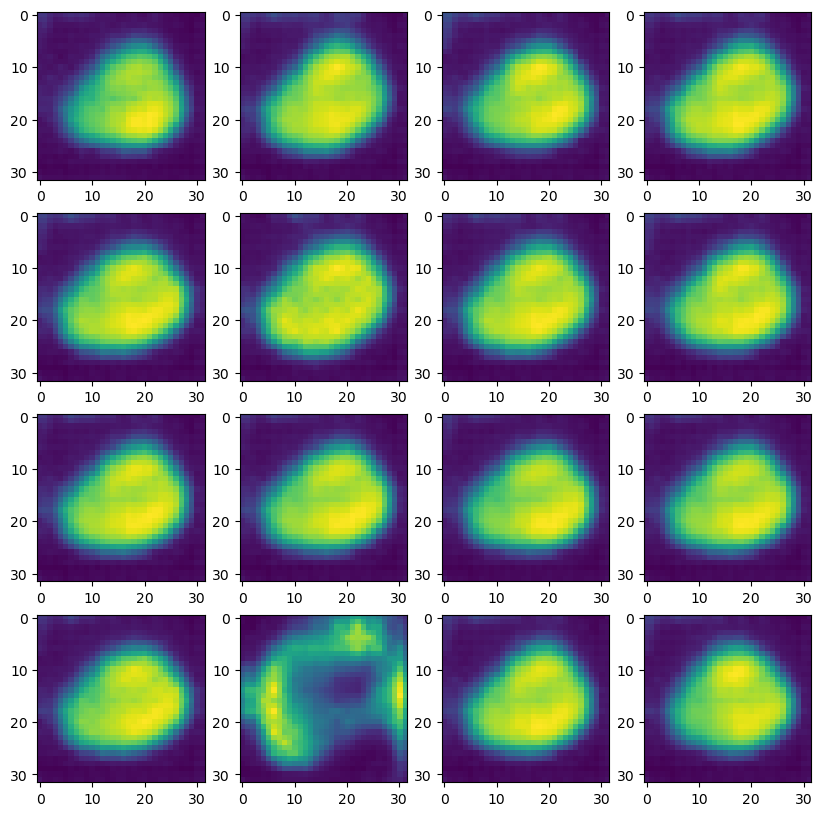

In [ ]:
# log_dir = os.path.join('logs', task, '2023-07-17_12-30-20')
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(recon_batch[i][0])
plt.savefig(os.path.join(log_dir, 'reconstruction.png'))
plt.show()

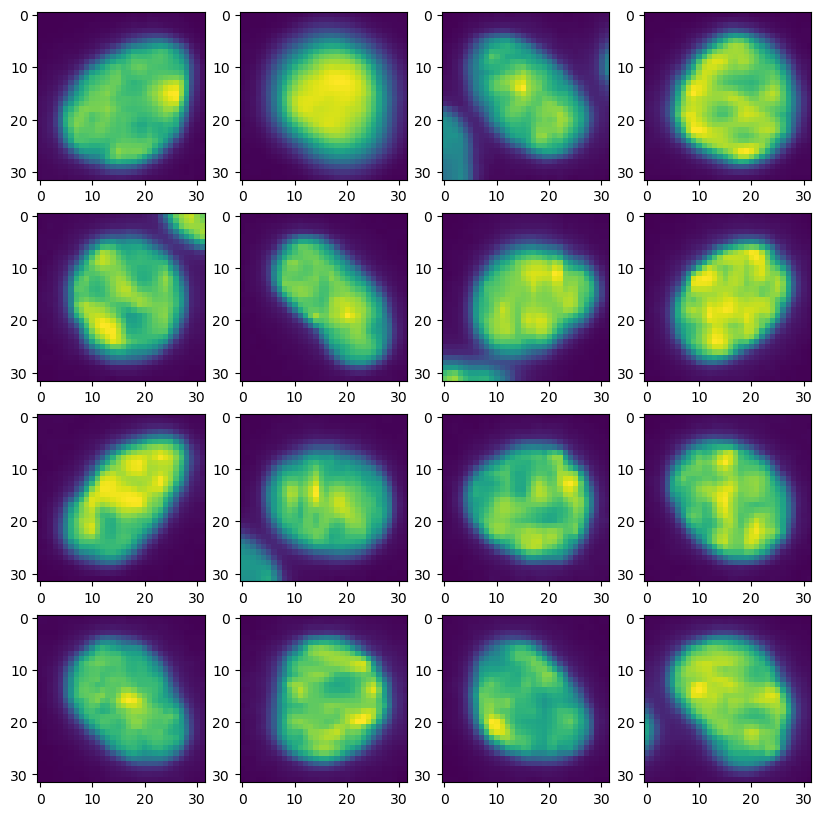

In [ ]:
data = data.cpu().numpy()
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(data[i][0])
plt.savefig(os.path.join(log_dir, 'original.png'))
plt.show()